### NC Files: Lectura de archivos y preparación del input para la U-net.

La idea de este notebook es servir como pauta y *ayudamemoria* para su autoreproducibilidad. Atenderemos la configuración del espacio de trabajo, las librerías utilizadas (para Windows) y algunas precauciones. Por último, es importante recalcar que el código es una adaptación al realizado para los archivos **.grib2** y **.grb2**

####  Espacio de trabajo: 

La disposición de las carpetas y archivos necesarios para ejecutar este notebook es la siguiente:

$\; \; \; \;$ **Data** <br>
$\; \; \; \;$ |__ **forecasted/** (inp) <br>
$\; \; \; \; \; \; \; \; \;$ |__ **2006/** <br>
$\; \; \; \; \; \; \; \; \; \; \; \; \; \; \;$ |__ **2006101000/**<br>
$\; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; $  |__ GFS0.5_t2m_heightAboveGround_instant_2006101000.nc <br>
$\; \; \; \;$ |__ **observed/** (target) <br>
$\; \; \; \; \; \; \; \; \;$ |__ **2006/** <br>
$\; \; \; \; \; \; \; \; \; \; \; \; \; \; \;$ |__ era5-land_200610*.nc  <br>
$\; \; \; \; \; \; \; \; \; \; \; \; \; \; \;$ |__ dem.nc  <br>
$\; \; \; \;$ |__ [A1_guiaNC.ipynb](A1_guiaNC.ipynb) (este archivo) <br> 
$\; \; \; \;$ |__ [A2_test3NC.ipynb](A2_test3NC.ipynb) (Preprocesamiento de los parches completo) <br> 
$\; \; \; \;$ |__ [B1_readNCdata.py](B1_readNCdata.py) (Clases y funciones relacionadas al preprocesamiento de la data)  <br>
$\; \; \; \;$ |__ [B2_Model.py](B2_Model.py) (Arquitectura de la U-net)  <br>
$\; \; \; \;$ |__ [C1_parches.npy](C1_parches.npy) (Almacenamiento de parches preprocesados)  <br>
$\; \; \; \;$ |__ [Extra_target_nan.ipynb](Extra_target_nan.ipynb) (Se expone el problema de los Nan en el target)  <br>
####  Librerías:
- Entorno conda: 

```conda create -n <nombre_env> python=3.10.4```
- dependencias

| Librería | Versión | Método |
|----------|---------| ------ |
| ipykernel | -- | pip |
| matplotlib | 3.6.2 | pip
| tensorflow | 2.11.0      | pip 
| xarray   |  2022.11.0 | pip
| dask | 2022.5.0 | pip
| cfgrib | 0.9.10.3 | pip
| scipy | 1.9.3 |  pip
| netcdf4 | 1.6.2 | pip
| h5netcdf | 1.1.0 | pip
| tqdm | 4.64.1 | pip 
| jinja2 |  3.1.2  | pip

Nota 1: En caso de error con la importación del paquete *cfgrib*, se debe tipear la siguiente linea que complementará la instalación del paquete *cfgrib*:

```conda install -c conda-forge eccodes```

Nota 2: La versión de *eccodes* utilizada es la 1.5.0

####  Ejemplo de lectura de archivos .nc:

In [1]:
import xarray as xr
import tensorflow as tf
import glob
import os
import numpy as np
from tqdm import tqdm

Ejemplo data input:

In [2]:
data_ex = xr.open_dataset('Data/forecasted/2006/2006101100/GFS0.5_t2m_heightAboveGround_instant_2006101100.nc')
data_ex

c:\Users\ruben\anaconda3\envs\dwn_104\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:            (valid_time: 41, latitude: 97, longitude: 33)
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 281.0 281.5 282.0 ... 296.5 297.0
  * valid_time         (valid_time) datetime64[ns] 2006-10-11 ... 2006-10-16
Data variables:
    t2m                (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-08T15:26 GRIB to CDM+CF via cfgrib-0.9.1...

Atributo "Data variable" que nos interesa: 

In [4]:
data_t2m=data_ex['t2m']
data_t2m

<xarray.DataArray 't2m' (valid_time: 41, latitude: 97, longitude: 33)>
[131241 values with dtype=float32]
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 281.0 281.5 282.0 ... 296.5 297.0
  * valid_time         (valid_time) datetime64[ns] 2006-10-11 ... 2006-10-16
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

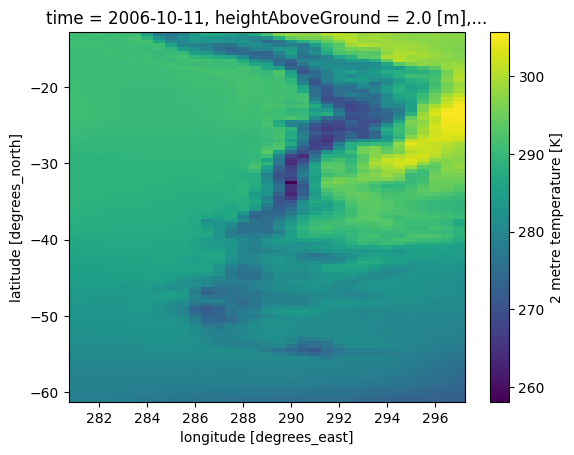

In [5]:
data_t2m[0,:,:].plot()

Ejemplo data target:

In [6]:
data_target = xr.open_dataset('Data//observed/2006/era5-land_20061010.nc')
data_target

<xarray.Dataset>
Dimensions:    (longitude: 101, latitude: 401, time: 24)
Coordinates:
  * longitude  (longitude) float32 -75.0 -74.9 -74.8 -74.7 ... -65.2 -65.1 -65.0
  * latitude   (latitude) float32 -15.0 -15.1 -15.2 -15.3 ... -54.8 -54.9 -55.0
  * time       (time) datetime64[ns] 2006-10-10 ... 2006-10-10T23:00:00
Data variables: (12/13)
    t2m        (time, latitude, longitude) float32 ...
    pev        (time, latitude, longitude) float32 ...
    asn        (time, latitude, longitude) float32 ...
    snowc      (time, latitude, longitude) float32 ...
    rsn        (time, latitude, longitude) float32 ...
    sde        (time, latitude, longitude) float32 ...
    ...         ...
    e          (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    swvl1      (time, latitude, longitude) float32 ...
    swvl2      (time, latitude, longitude) float32 ...
    swvl3      (time, latitude, longitude) float32 ...
    swvl4      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-01 22:02:19 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Mismo atributo "Data variable" que nos interesa:

In [7]:
data_target_t2m=data_target['t2m']
data_target_t2m

<xarray.DataArray 't2m' (time: 24, latitude: 401, longitude: 101)>
[972024 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -75.0 -74.9 -74.8 -74.7 ... -65.2 -65.1 -65.0
  * latitude   (latitude) float32 -15.0 -15.1 -15.2 -15.3 ... -54.8 -54.9 -55.0
  * time       (time) datetime64[ns] 2006-10-10 ... 2006-10-10T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

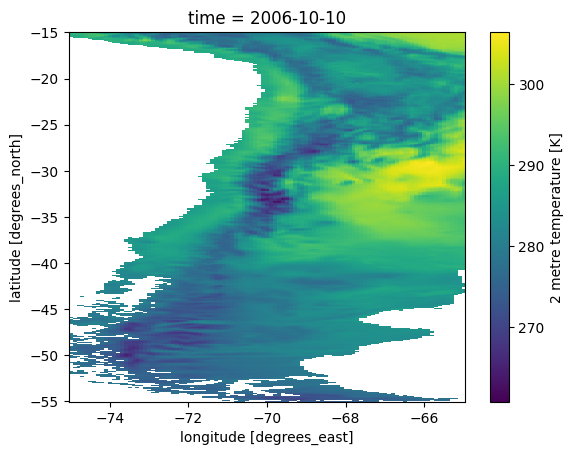

In [8]:
#Primer registro de tiempo
data_target_t2m[0,:,:].plot()

####  Adaptación de las clases a los nuevos archivos .nc:

Contamos con 3 clases principales que nos permitirán leer los archivos .nc y preparar los tensores para el input de la U-net. Desmenuzaremos sus líneas de código para entender mejor su funcionamiento.

##### Primera clase: Gridded

In [10]:
import warnings

class Gridded:
    ''' Clase básica introductoria que permite manejar y setear las primeras variables relacionadas a la ruta de los archivos a leer.
        Además, permite chequear la existencia de atributos propios de la data y atributos propios de la clase instanciada.
    '''
    
    def __init__(self, fName='*', path='./'):
        self.fName = fName #Nombres de los archivos a importar [str]
        self.path = path #ruta (path) de estos archivos. [str]

    def __value__(self, val, vals):
        '''Método que chequea la existencia de un atributo relacionado a "Data Variable"
        inp:
            val: [str] Atributo de "Data Variable" que se quiere chequear
            vals: [List] Lista con todos los atributos de "Data Variable"
        '''

        if val in vals:
            return val
        else:
            warnings.warn(val + " is not a possible value, using: " + vals[0])
            return vals[0]

    def getMyAttributes(self):
        '''Retorna los atributos propios de la clase instanciada dado las siguientes condiciones:
        no comienzan con '__', no son calleables ( '__call__()') y no son propios de una clase (genérica) como tal. 
        '''    
        return [a for a in dir(self) if
                not a.startswith('__') and not callable(getattr(self, a)) and not a in dir(Gridded)]

    def __str__(self):
        '''Método especial para printear cada vez que instanciamos nuestra clase.'''

        txt = "Class: gridded\n"
        for att in self.getMyAttributes():
            val = getattr(self, att)
            if type(val) is list:
                txt = txt + "  " + att + ":\n"
                for v in val:
                    txt = txt + "    " + str( v ) + "\n"
            else:
                txt = txt + "  " + att + ": " + str(getattr(self, att)) + "\n"
        return (txt)

    def __repr__(self):
        '''Método que convierte el objeto en una cadena'''       
        return self.__str__()

Ejemplo de los métodos de Gridded:

In [11]:
class_gridded= Gridded('GFS0.5_2tm_*.nc', path='forecasted/2006/2006101000/GFS0.5_t2m_heightAboveGround_instant_2006101000.nc')
class_gridded

Class: gridded
  fName: GFS0.5_2tm_*.nc
  path: forecasted/2006/2006101000/GFS0.5_t2m_heightAboveGround_instant_2006101000.nc

In [12]:
class_gridded.getMyAttributes()

['fName', 'path']

In [13]:
metodo_repr=class_gridded.__repr__()
print(type(metodo_repr))
metodo_repr

<class 'str'>


'Class: gridded\n  fName: GFS0.5_2tm_*.nc\n  path: forecasted/2006/2006101000/GFS0.5_t2m_heightAboveGround_instant_2006101000.nc\n'

##### Segunda clase: GFSVar

Para efectos de los archivos .nc que conformarán el input, solo contamos con el atributo ```typeOfLevels = heightAboveGround``` (a diferencia de la decena de atributos que se tenían originalmente para los archivos grib2 y grb2).

Nota: Para efectos de los archivos relacionados a la orografía, contamos únicamente con el atributo ```typeOfLevels = surface```

In [14]:
data_t2m.GRIB_typeOfLevel

'heightAboveGround'

In [15]:
class GFSVar:
    '''Segunda clase básica que permite setear atributos importantes para extraer los DataArrays correctos del Dataset original. Su principal función será guardar la triada:
    (cfVarName: atributo de "Data Variable" para extraer el DataArray 
    typeOfLevel:  atributo typeOfLevel propio del DataArray
     long_name: nombre extendido del atributo de "Data Variable" definido anteriormente)
    '''

    #Atributos de clase propios de los archivos .nc
    typeOfLevels = [ 'surface','heightAboveGround']

    def __init__(self, cfVarName, typeOfLevel, long_name=''):
        self.cfVarName = cfVarName  #[str] Atributo de "Data Variable" a utilizar. (Ej: 't2m' o 'Band1')
        self.typeOfLevel = typeOfLevel #[str] Atributo typeOfLevel de nuestro DataArray
        self.value = None
        if long_name != '': 
            self.long_name = long_name #[str] Atributo de nuestro DataArray, representa el nombre extendido de cfVarName

    def __str__(self):
        '''método especial de printeo para el instanciamiento de la clase.
        '''
        return self.cfVarName + ", " + self.typeOfLevel + ", " + self.long_name

    def __repr__(self):
        ''' método especial que retorna el objeto como string.
        '''
        return self.__str__()

##### 1.3-. Tercera clase: NCFile

Esta tercera clase es la que se encarga de todo el trabajo pesado. Dividiremos sus métodos en "bloques" para facilitar su comprensión. Cada bloque comprende a los métodos que interactúan entre sí y que estarán asociados a una línea de código concreto basado en la estructura del archivo *test3.ipynb*: 

In [68]:
class NCFile(Gridded):
    ''' Clase principal para el preprocesamiento de los inputs. Está encargada de la importación, estandarización de variables, creación de parches,
        normalización y división de la data.
        Hereda los atributos de instancia de Gridded.
    '''

    #Atributos de clase por default:
    max_lat = -17.
    min_lat = -57.
    min_lon = 360. - 76. #80.
    max_lon = 360. - 66. #64.
    dx = 32 # >0 #corte de los parches en el espacio
    dt = 3 # >0 #corte de los parches en el tiempo
    shift = 1 # >0 & < dx
    method = 'linear' #{"linear", "nearest", "zero", "slinear", "quadratic", "cubic", "polynomial", "barycentric", "krog", "pchip", "spline", "akima"}

    def __init__(self, fName='*', path='./'):
        super().__init__(fName, path) #Atributos heredados de Gridded
        
        self.currentVar = None #[str] atributo de "Data Variable" que nos interesa.
        self.vars = None  #None #[List] Contiene la información seteada por la clase GFSVar.
        self.values = None
        self.__getVars__()

        # predef values for methods
        self.max_lat = NCFile.max_lat
        self.min_lat = NCFile.min_lat
        self.min_lon = NCFile.min_lon
        self.max_lon = NCFile.max_lon
        self.dx = NCFile.dx
        self.dt = NCFile.dt
        self.shift=NCFile.shift
        self.method = NCFile.method


    ##### Bloque 1
    ### Bloque 1.1
    def __getFirstFile__(self):
        ''' Recibe el path y el fName (desde Gridded) y retorna su ruta como str en caso de que exista.
        '''
        try:
            ff = sorted(glob.glob(self.path + self.fName))[0]
            if os.path.isfile(ff):
                return ff
            else:
                raise Exception('NCFile:__getFirstFile__:File not found')
        except:
            raise Exception('NCFile:__getFirstFile__:File not found')

    def __getVars__(self):
        ''' Accedemos a la data y guardamos su información: Data Variables, typeOfLevel y data[data_variable].attrs['long_name']
        '''
        self.vars = []
        thisFile = self.__getFirstFile__()
        tmp = xr.open_dataset(thisFile)
        if "era5" or "dem" in thisFile:
            for var in list(tmp.keys()):
                thisVar = GFSVar(var, 'none', tmp[var].attrs['long_name']) 
                self.vars.append(thisVar)
        else:
            var=list(tmp.keys())[0]
            thisVar = GFSVar(var, tmp[var].GRIB_typeOfLevel , tmp[var].attrs['long_name'])   
            self.vars.append(thisVar)

    ###Bloque 1.2:
    def getVarMetaData(self, var='', tol='*'):
        if var == '':
            return [a for a in self.vars]
        elif tol not in GFSVar.typeOfLevels:
            return [a for a in self.vars if a.cfVarName == var]
        else:
            return [a for a in self.vars if ((a.cfVarName == var) and (a.typeOfLevel == tol))]

    def setVar(self, var, tol='*'):
        ''' Definiremos al atributo de instancia currentVar como la triada obtenida al instanciar GFSVar (mismos valores)
        '''

        #triada list var/tol/var_long
        varData = self.getVarMetaData(var=var, tol=tol)
        
        if len(varData) > 1:
            for tvar in varData:
                print(tvar)
            raise Exception('Not single variable for var=' + var + ' and typeOfLevel=' + tol + '.\nTry specifying tol.')
        else:
            varData = varData[0]
        self.currentVar = varData
        return self.currentVar

    #Bloque 1.3: 
    def loadVar(self):
        '''Método que nos permite importar los distintos tipos de archivos (era5, dem, etc), estandarizar sus atributos internos y 
            retornar el DataArray definido por cfVarName (atributo self.values).

        Estandarización realizada:
            Para era5: cambiamos el nombre de la variable "time" y tomamos cada 3 tiempos. (total 40 tiempos)
            Para dem: cambiamos el nombre de lon y lat.
            Para GFS0.5: estandarizamos los valores de longitud y descartamos el último registro de tiempo (total 40 tiempos.)
        '''
        
        if "era5" in self.fName:
            self.values = xr.open_mfdataset(self.path + self.fName, concat_dim='time', combine='nested')
            self.values = self.values.rename( {'time':'valid_time'})
            self.values= self.values[self.currentVar.cfVarName][::3,:,:]

        elif "dem"in self.fName:
            self.values = xr.open_mfdataset(self.path + self.fName, concat_dim='time', combine='nested')
            self.values = self.values.rename( {'lon':'longitude', 'lat': 'latitude'})
            self.values= self.values[self.currentVar.cfVarName]

        else:
            self.values = xr.open_mfdataset(self.path + self.fName,
                                        concat_dim='valid_time', combine='nested')
            data_import= self.values[self.currentVar.cfVarName]
            self.values=data_import.assign_coords({'longitude':data_import.longitude.values-360})
            self.values=self.values[:-1,:,:]

        return self.values.copy()

    #Bloque 1.4:   
    def upscaleVar(self, other, method=method):
        '''Método que interpola linealmente (default) las dimensiones del DataArray definido (values) de tal manera que tenga las mismas dimensiones
            que el DataArray dado
        inputs:
            other: [DataArray] DataArray sobre el cual se quiere compatibilizar las dimensiones
            method: [str] Método de interpolación, default='linear'
        return:
            self.values.copy(): [DataArray] Copia del DataArray sobre el cual se aplicó la interpolación y cuyas dimensiones son las mismas que 'other'.
        '''
        self.method = method
        self.values = self.values.interp_like(other, method=self.method)
        return self.values.copy()  
 
    #####Bloque 2: 
    ### Bloque 2.1:   
    def extraccion_parches(self,Var, dx=dx):

        '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
        '''
    
        stack = tf.stack([],axis=0)

        #recorremos en el tiempo
        for dt in tqdm(range(0,38)):
            #recorremos en la latitude
            for dlat in range(0,401-dx,dx):
                #recorremos en la longitude
                for dlong in range(0,101-dx,dx):  
                    #Cortamos parches de 32x32 en 3 tiempos             
                    parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                    #si el stack no está vacío, concatenamos los parches
                    if tf.equal(tf.size(stack), 0) == False:
                        parche = tf.expand_dims(parche, axis=0)
                        stack= tf.concat((stack, parche), axis=0)
                        #y pasamos a la siguiente iteración
                        continue
                
                    #si el stack está vacío, lo inicializamos
                    stack=tf.stack([parche],axis=0)
        patches = tf.expand_dims(stack, 4) 
        print("Stack patches shape: ",patches.shape)               
        return patches

    def getVar(self):
        ''' Método que retorna una copia del DataArray. Se puede reemplazar por la llamada directa al atributo.
        '''
        return self.values.copy()             
    ## --- ##

    ### Bloque 2.2: Latitude
    def sampleLat(self):
        ''' Compatibiliza y adapta las dimensiones de los valores de la latitud del DataArray (guardado en values) a las dimensiones
            del propio DataArray.
        return:
            self.extraccion_parches(Var=lat): [tensor] Retorna la salida de la función extracion_parches( Var=lan)
        '''
        ll = tf.constant(self.values.latitude.values)
        vv = self.values.shape
        lat = tf.transpose(tf.broadcast_to(ll, [vv[0], vv[2], vv[1]]), perm=(0, 2, 1))
        return self.extraccion_parches(Var=lat)
    ## --- ##

    #### Bloque 2.3: Longitude
    def sampleLon(self):
        ''' Compatibiliza y adapta las dimensiones de los valores de la longitud del DataArray (guardado en values) a las dimensiones
            del propio DataArray.
        return:
            self.extraccion_parches(Var=lon): [tensor] Retorna la salida de la función extracion_parches( Var=lon)
        '''
        ll = tf.constant(self.values.longitude.values)
        vv = self.values.shape         
        lon = tf.broadcast_to(ll, vv)
        return self.extraccion_parches(Var=lon)
    ## --- ##

    #### Bloque 2.4: orog
    def sampleBand1(self):
        ''' Preprocesa los archivos relacionados a la orografía instanciándolos en una nueva clase y aplicando los mismos métodos que se emplearon para el input y el target 
            para posteriormente extraer sus parches.
            Parte del preprocesamiento conlleva reemplazar los datos Nan por ceros y concatenar los valores del tensor completo una cantidad de veces suficiente para que sus 
            dimensiones coincidan con las del DataArray.
        return:
            self.extraccion_parches(Var=stack_time): [tensor] Retorna la salida de la función extracion_parches( ) aplicada a los valores de stack_time.
        '''
        band1 = NCFile(fName= 'dem.nc', path='./Data/observed/2006/')
        band1.setVar('Band1')
        band1.loadVar()
        band1.upscaleVar(self.values)
        band1.values=tf.where(tf.math.is_nan(band1.values),tf.zeros_like(band1.values),band1.values)
        stack_time=tf.repeat(band1.values, 40, axis=0)
        return band1.extraccion_parches(Var=stack_time)
        ## --- ##
    
    ### Bloque 2.5:
    def sampleDayOfYear(self):
        ''' Método encargado de la adaptabilidad y compatibilidad de dimensiones de la variable 'valid_time' con el DataArray. Utiliza el tensor que contiene los nanosegundos transcurridos
            desde inicio de año hasta la fecha registrada en self.values.valid_time como base.
        return:
            time1 = self.extraccion_parches(Var=time) Retorna la salida de la función extracion_parches( ) aplicada a los valores de time.
            time2 = self.extraccion_parches(Var=time) Retorna la salida de la función extracion_parches( ) aplicada a los valores de time pero con un stride de 4.
        '''
        d = self.values.valid_time
        dd = (d-d.astype('M8[Y]')).astype(float) 
        ll = tf.constant(dd) 
        vv = self.values.shape 
        time = tf.transpose(tf.broadcast_to(ll, [vv[1], vv[2], vv[0]]), perm=(2,0,1))
        time1 = self.extraccion_parches(Var=time)
        time2 = self.extraccion_parches(Var=time, dx=4)

        return time1, time2 
    ## --- ##

    ##### Bloque 3: 
    def cantidad_nan(self,inputs=[]):
        '''Recorre cada variable que conforma el input de la red, y cuenta los valores nan de cada uno.
        inputs:
            inputs: [List] Lista con los inputs de la red.
        '''
        inputs_name=["target","inp","lat","lot","orog","time1","time2"]
        cantidad=[];cont=0
        for inp in inputs:
            check_nan= tf.math.is_nan(inp[:,0,:,:,0])
            cont=np.sum(check_nan)
            cantidad.append(cont)

        for nombre,num in zip(inputs_name,cantidad):
            print(f"{nombre}- num valores nan: {num}")

    def parches_nan_target(self,patch_target):
        ''' Recorremos cada parche dentro de target y contamos sus valores Nan, si estos resultan igual a la cantidad de elementos de dicho parche
        (32*32=1024) guardamos su índice en una lista.
        inp:
            patch_target: [tensor] tensor que contiene los parches extraídos de target

        return:
            idx: [list] posición de los parches que no están completamente compuestos con Nan's
        '''
        idx_nulos=[]

        for i in range(patch_target.shape[0]):
            check_nan= tf.math.is_nan(patch_target[i,0,:,:,0])
            if np.sum(check_nan) == patch_target.shape[2]* patch_target.shape[3]: #32*32
                idx_nulos.append(i)
        print("Cantidad de parches nulos: ",len(idx_nulos))

        #filtramos las posiciones de los parches completos de Nan's
        idx= [x for x in range(0,patch_target.shape[0]) if x not in idx_nulos]
        print("Cantidad de parches no nulos: ",len(idx))
        return idx

    def filtracion_nan(self,target,inp,lat,lon,orog,time1,idx):
        ''' A través del método tf.gather(), descarta los parches completos de Nan y retorna los nuevos parches que conformarán el input de la red.
        input:
            -target,inp,lat,lon,orog,time1: [tensor] tensor que contiene los parches de cada variable que conforma al input
            idx: [list] Poisición de los parches que no están completados únicamente con Nan
        return:
         Retorna los nuevos parches limpios para cada variable.
        '''
        target_clean=tf.gather( target, idx, axis=0)
        inp_clean=tf.gather( inp, idx, axis=0)
        lat_clean=tf.gather( lat, idx, axis=0)
        lon_clean= tf.gather( lon, idx, axis=0)
        orog_clean = tf.gather( orog, idx, axis=0)
        time1_clean = tf.gather( time1, idx, axis=0)

        return target_clean, inp_clean, lat_clean, lon_clean, orog_clean, time1_clean
    
    def normalization(self, data_in=input,inverse=False, scale_factor=[1,1]):
        '''Método que normaliza los valores entregados.
        input:
            data_in: [tensor] Tensor con los parches de la variable que forma parte del input de la Red
            inverse: [Boolean, default=False] True en caso de devolver la transformación
        return: 
            variable normalizada
        '''
        if not inverse:
            scale_factor_ = np.max(np.abs(data_in))
            scale_factor_2 = np.min(np.abs(data_in))
            data_out = (data_in-scale_factor_2)/(scale_factor_ - scale_factor_2)
            scale_factor_ = [scale_factor_,scale_factor_2]
        else:
            data_out=(data_in * (scale_factor[0]-scale_factor[1]))+scale_factor[1]
            scale_factor_ = scale_factor
        return data_out, scale_factor_
    
    def mysplit(self, inp, time, orog, lat, lon, target):
        ''' Método encargado de la división  de todas las variables que conforman el input de la red en: entrenamiento (60%), validación (20%) y testeo.
        return:
            división de cada variable en testeo, validación y testeo.
        '''
        data = tf.concat([tf.cast(inp, dtype=tf.float32),
                      tf.cast(time, dtype=tf.float32),
                      tf.cast(orog, dtype=tf.float32),
                      tf.cast(lat, dtype=tf.float32),
                      tf.cast(lon, dtype=tf.float32),
                      tf.cast(target, dtype=tf.float32)], axis=4)
        data = tf.random.shuffle(data, seed=10)
        n = data.shape[0]
        n_train = int(n * .6)
        n_valid = int(n * .2)
        n_test = n - n_train - n_valid
        data = tf.split(data, [n_train, n_valid, n_test])
        return (tf.expand_dims(data[0][:, :, :, :, 0],4),
            tf.expand_dims(data[0][:, :, :, :, 1],4),
            tf.expand_dims(data[0][:, :, :, :, 2],4),
            tf.expand_dims(data[0][:, :, :, :, 3],4),
            tf.expand_dims(data[0][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[0][:,1,:,:,5],1),4),
            tf.expand_dims(data[1][:, :, :, :, 0],4),
            tf.expand_dims(data[1][:, :, :, :, 1],4),
            tf.expand_dims(data[1][:, :, :, :, 2],4),
            tf.expand_dims(data[1][:, :, :, :, 3],4),
            tf.expand_dims(data[1][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[1][:,1,:,:,5],1),4),
            tf.expand_dims(data[2][:, :, :, :, 0],4),
            tf.expand_dims(data[2][:, :, :, :, 1],4),
            tf.expand_dims(data[2][:, :, :, :, 2],4),
            tf.expand_dims(data[2][:, :, :, :, 3],4),
            tf.expand_dims(data[2][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[2][:,1,:,:,5],1),4))

Replicaremos la primera parte del código en *test3.ipynb* consistente en la carga de los datos:

#### (1) Primera parte: importación de la data y definición de atributos importantes:  <br>
Nota: Código extraído del archivo test3.ipynb original (para los archivos grib2 y grb2)

```
#inp values:
g05 = gfs.GribFile('gfs_4_*.grb2', path='./0.50deg/gfs_4_2021010100.g2/junior_grb2/')
#g05 = gfs.GribFile('gfs_4_20210101_0000_123.grb2', path='./0.50deg/gfs_4_2021010100.g2/Extradays/')
g05.setVar('t2m')
g05.loadVar()
g05.cropVar()
```
```
#target values:
g025 = gfs.GribFile('gfs.0p25*.grib2', path='./0.25deg/gfs.0p25.2021010100.grib2/junior_grib2/')
g025.setVar('t2m')
g025.loadVar()
g025.cropVar()

g05.upscaleVar(g025.values)
```

Comentario: mostraremos las salidas de algunos métodos de esta clase que no son explícitamente utilizados en el código original.

##### (1.A) Para efectos de la variable *input* 

Instanciamos nuestra clase NCFile:

In [21]:
ncfile= NCFile('GFS0.5_t2m_heightAboveGround_instant_200610*.nc', path='./Data/forecasted/2006/2006101000/')

Atributos propios de la clase NCFile:

In [22]:
for att in ncfile.getMyAttributes():
    val = getattr(ncfile, att)
    print("att: ", att, ": ", val, " ", type(val))

att:  currentVar :  None   <class 'NoneType'>
att:  dt :  3   <class 'int'>
att:  dx :  32   <class 'int'>
att:  fName :  GFS0.5_t2m_heightAboveGround_instant_200610*.nc   <class 'str'>
att:  max_lat :  -17.0   <class 'float'>
att:  max_lon :  294.0   <class 'float'>
att:  method :  linear   <class 'str'>
att:  min_lat :  -57.0   <class 'float'>
att:  min_lon :  284.0   <class 'float'>
att:  path :  ./Data/forecasted/2006/2006101000/   <class 'str'>
att:  shift :  1   <class 'int'>
att:  values :  None   <class 'NoneType'>
att:  vars :  [t2m, none, 2 metre temperature]   <class 'list'>


Contamos con solo un archivo a importar:

In [24]:
path='./Data/forecasted/2006/2006101000/'
fName='GFS0.5_t2m_heightAboveGround_instant_*.nc'

file_1 = sorted(glob.glob(path + fName))
file_1

['./Data/forecasted/2006/2006101000\\GFS0.5_t2m_heightAboveGround_instant_2006101000.nc']

**(1.1) Bloque 1:**
- __ getFirstFile __( )
- __ getVars __( )

**__ getFirstFile( ) __:** 

In [25]:
def __getFirstFile__(self):
    ''' Recibe el path y el fName (desde Gridded) y retorna su ruta como str en caso de que exista.
    '''
    try:
        ff = sorted(glob.glob(self.path + self.fName))[0]
        if os.path.isfile(ff):
            return ff
        else:
            raise Exception('NCFile:__getFirstFile__:File not found')
    except:
        raise Exception('NCFile:__getFirstFile__:File not found')

Descripción del método: <br><br>
Dado el path y el fName (nombre de los archivos a importar) definidos al instanciar la clase NCFile, comprobamos si la ruta especificada para el archivo existe y de ser así, retornamos su ruta como str.

In [26]:
ff = sorted(glob.glob(ncfile.path + ncfile.fName))[0]
ff

'./Data/forecasted/2006/2006101000\\GFS0.5_t2m_heightAboveGround_instant_2006101000.nc'

In [27]:
if os.path.isfile(ff):
    print("El archivo existe!")
else:
    print("Archivo no encontrado")

El archivo existe!


**__ getVars __ ( ):**

In [28]:
def __getVars__(self):
    ''' Accedemos a la data y guardamos su información: Data Variables, typeOfLevel y data[data_variable].attrs['long_name']
    '''

    self.vars = []
    #path específico de cada archivo
    thisFile = self.__getFirstFile__()
    tmp = xr.open_dataset(thisFile)
        
   #Guardamos la triada (tmp.keys()[i] / typeOfLevel[j] / tmp[var].attrs['long_name'] en una lista)

    if "era5" or "dem" in thisFile:
        for var in list(tmp.keys()):
            thisVar = GFSVar(var, 'none', tmp[var].attrs['long_name']) 
            self.vars.append(thisVar)
    else:
        var=list(tmp.keys())[0]
        thisVar = GFSVar(var, tmp[var].GRIB_typeOfLevel , tmp[var].attrs['long_name'])   
        self.vars.append(thisVar)

Descripción del método: <br><br>
Inicializamos como lista el atributo de instancia: ``` self.vars ``` y definimos dos variables más: ```thisFile```, que contiene la ruta como str retornado por el método **__ getFirstFile __( )**, y ```tmp```, que importa (como xarray.Dataset) directamente los archivos .nc desde su ruta (<code>thisFile<code>)

In [29]:
tmp = xr.open_dataset(ff)
tmp

<xarray.Dataset>
Dimensions:            (valid_time: 41, latitude: 97, longitude: 33)
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 281.0 281.5 282.0 ... 296.5 297.0
  * valid_time         (valid_time) datetime64[ns] 2006-10-10 ... 2006-10-15
Data variables:
    t2m                (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-08T15:22 GRIB to CDM+CF via cfgrib-0.9.1...

Posterior a esto, definimos la variable ```var``` [str] como el primer elemento  obtenido de ```tmp.keys()```. Este método propio de los xarray.Dataset contiene las distintas "Data Variables" (ver celda anterior) importadas, en nuestro caso únicamente será 't2m' (como str).

In [30]:
var=list(tmp.keys())[0]
print("list(tmp.keys()[0]): ",var)
tmp['t2m']

list(tmp.keys()[0]):  t2m


<xarray.DataArray 't2m' (valid_time: 41, latitude: 97, longitude: 33)>
[131241 values with dtype=float32]
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 281.0 281.5 282.0 ... 296.5 297.0
  * valid_time         (valid_time) datetime64[ns] 2006-10-10 ... 2006-10-15
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

Finalmente definimos la variable ```thisVar``` como objeto de la clase GFSVar. Los inputs para esta clase son:
- ```var:``` [str] Descrita anteriormente. Contiene al único atributo  del DataArray. Estará definida como 't2m'. 
- ```tmp[var].GRIB_typeOfLevel:``` [str] Contiene al atributo "typeOfLevel" propio de los archivos '.nc' Para ser llamado requiere de un DataArray (en nuestro caso está dado por tmp['t2m'])
- ```tmp[var].attrs['long_name']:``` [str] Contiene al nombre extendido de la variable var (definida como 't2m'). Para ser llamado requiere de un DataArray: tmp['t2m']

Importante: Cuando tengamos que importar otro tipo de archivos (sea 'era5' o 'dem'), reemplazaremos el atributo 'typeOfLevel' por 'none' debido a que no existe este atributo para ése tipo de archivos.

In [31]:
print("var: ",var)
print("tmp[var].GRIB_typeOfLevel: ", tmp[var].GRIB_typeOfLevel)
print("tmp['t2m'].attrs['long_name'] ", tmp['t2m'].attrs['long_name'])
thisVar = GFSVar(var,  tmp[var].GRIB_typeOfLevel, tmp[var].attrs['long_name'])
thisVar

var:  t2m
tmp[var].GRIB_typeOfLevel:  heightAboveGround
tmp['t2m'].attrs['long_name']  2 metre temperature


t2m, heightAboveGround, 2 metre temperature

Inicializado el atributo de instancia ```self.vars``` al comienzo del método, guardaremos el contenido del objeto thisVar dentro de esta variable, que será tipo lista y contendrá la triada de variables (tipo str) que contiene thisVar pero, valga de la redundancia, en formato de lista y de tamaño 1.

In [32]:
ncfile_vars=[]
ncfile_vars.append(thisVar)
print("Cantidad de elementos: ",len(ncfile_vars))
print(ncfile_vars)

Cantidad de elementos:  1
[t2m, heightAboveGround, 2 metre temperature]


Paréntesis: Hablemos de la clase GFSVar.

Ahora que ya entendemos un poco mejor los atributos que esta clase requiere, podemos notar como la principal función de GFSVar es definir los siguientes atributos de instancia, que posteriormente serán heredados a la clase mayor: NFCile (por decirlo de alguna manera)

- ```cfVarName:``` [str] Contiene al único atributo de "Data variables" como string proveniente del xarray.Dataset importado. En nuestro caso será 't2m'. 
- ```typeOfLevel:```[str] Estará definido por el typeOfLevel propio del Datarray que hayamos importado. Para efectos de la data input, solo será 'heightAboveGround' (para el resto, puede variar entre éste y 'surface')
- ```long_name```:[str] Return del método ```.attrs['long_name']``` aplicado a nuestro Datarray. Corresponde a la versión extendida de ```CfVarName```

Nota: ```self.value``` se definirá más adelante.

In [33]:
class GFSVar:

    #Atributos de clase propios de los archivos .nc
    typeOfLevels = [ 'surface','heightAboveGround']

    def __init__(self, cfVarName, typeOfLevel, long_name=''):
        self.cfVarName = cfVarName
        self.typeOfLevel = typeOfLevel
        self.value = None
        if long_name != '':
            self.long_name = long_name

    def __str__(self):
        return self.cfVarName + ", " + self.typeOfLevel + ", " + self.long_name

    def __repr__(self):
        return self.__str__()

##### (1.2) Bloque 2:
- getVarMetaData( )
- setVar( )

In [34]:
def getVarMetaData(self, var='', tol='*'):
    if var == '':
        return [a for a in self.vars]
    elif tol not in GFSVar.typeOfLevels:
        return [a for a in self.vars if a.cfVarName == var]
    else:
        return [a for a in self.vars if ((a.cfVarName == var) and (a.typeOfLevel == tol))]

Retorna una lista de tamaño 1 que contiene la información: [ Data Variable ('t2m'), typeOfLevel, Data Variable extendida]. En caso de no especificar la variable 'var', retorna lo mismo que el objeto que contiene a GFSVar. Si la variable 'tol' no es especificada, retorna los elementos de 'self.vars' que coincidan con la variable cfVarName especificada en la clase GFSVar. Ídem en caso de que ambos parámetros (val y tol) no estén especificados o no coincidan

LLamado del método dentro de setVar( )

In [35]:
var='t2m'; tol='*'
varData = ncfile.getVarMetaData(var=var, tol=tol)
print("type: ", type(varData))
print("tamaño: ",len(varData))
varData

type:  <class 'list'>
tamaño:  1


[t2m, none, 2 metre temperature]

In [36]:
def setVar(self, var, tol='*'):
    ''' Seteamos currentVar bajo algún criterio (revisar)
    '''

    #triada list var/tol/var_long
    varData = self.getVarMetaData(var=var, tol=tol)
        
    if len(varData) > 1:
        for tvar in varData:
            print(tvar)
        raise Exception('Not single variable for var=' + var + ' and typeOfLevel=' + tol + '.\nTry specifying tol.')
    else:
        varData = varData[0]
    self.currentVar = varData
    return self.currentVar

Aplicación:

In [37]:
ncfile.setVar('t2m')
print("currentVar: ",ncfile.currentVar)

currentVar:  t2m, none, 2 metre temperature


Este método gira en torno a definir correctamente (y asumiendo casos de existencia o no para efectos de ```var``` y ```tol```) el atributo de instancia ```currentVar```. Si bien resulta comprensible percibir que es un método innecesariamente complejo para tan pocos y específicos atributos, hay que recordar que estos métodos están basados en archivos de tipo grib2/grb2 que son muchos más pesados y con una mayor cantidad de atributos (lo cual le da el sentido a este proceso). Pero como nos interesa *adaptar* más que crear algo de cero, reciclaremos estos métodos.

Más adelante veremos la importancia de este atributo.

#### (1.3) Bloque 3: 
- loadVar( )

In [38]:
def loadVar(self):
        
    if "era5" in self.fName:
        self.values = xr.open_mfdataset(self.path + self.fName, concat_dim='time', combine='nested')
        self.values = self.values.rename( {'time':'valid_time'})
        self.values= self.values[self.currentVar.cfVarName][::3,:,:]

    elif "dem"in self.fName:
        self.values = xr.open_mfdataset(self.path + self.fName, concat_dim='time', combine='nested')
        self.values = self.values.rename( {'lon':'longitude', 'lat': 'latitude'})
        self.values= self.values[self.currentVar.cfVarName]

    else:
        self.values = xr.open_mfdataset(self.path + self.fName,
                                        concat_dim='valid_time', combine='nested')

        data_import= self.values[self.currentVar.cfVarName]
        self.values=data_import.assign_coords({'longitude':data_import.longitude.values-360})
        self.values=self.values[:-1,:,:]

    return self.values.copy()

Lo siguiente es estandarizar los distintos datos post importación, para ello tomaremos distintas medidas según cada archivo:
- Para los archivos ```era5```: Cambiaremos el nombre de la variable 'time' por 'valid_time' y tomaremos cada 3 tiempos, de tal manera de quedarnos únicamente con 40 (uno por día). Lo siguiente sería definir al atributo de instancia ```self.values``` como los valores asociados al datarray obtenido a través del atributo 't2m' (lo equivalente a tmp['t2m'])
- Para los archivos ```dem``` (relacionados al orog) : Cambiaremos el nombre de las variables "lon" y "lat" y definiremos como antes al atributo ```self.values```
- Para los archivos restantes: Estandarizamos los valores de la longitud restándole 360 a cada valor, quitamos el último tiempo para quedarnos con los primeros 40 y definimos ```self.values``` de la misma manera

Aplicamos el método que se encarga de todo esto:

In [39]:
ncfile.loadVar()

<xarray.DataArray 't2m' (valid_time: 40, latitude: 97, longitude: 33)>
dask.array<copy, shape=(40, 97, 33), dtype=float32, chunksize=(40, 97, 33), chunktype=numpy.ndarray>
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 -79.0 -78.5 -78.0 ... -63.5 -63.0
  * valid_time         (valid_time) datetime64[ns] 2006-10-10 ... 2006-10-14T...
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

Corresponde ahora repetir los bloques anteriores para los archivos relacionados al target:

##### **(1.B)** y **Bloque 1**

In [69]:
era5 =NCFile('era5-land_*.nc', path='./Data/observed/2006/')

##### **Bloque 2:**

In [70]:
era5.setVar('t2m')

t2m, none, 2 metre temperature

##### **Bloque 3:**

In [71]:
era5.loadVar()

<xarray.DataArray 't2m' (valid_time: 40, latitude: 401, longitude: 101)>
dask.array<getitem, shape=(40, 401, 101), dtype=float32, chunksize=(8, 401, 101), chunktype=numpy.ndarray>
Coordinates:
  * longitude   (longitude) float32 -75.0 -74.9 -74.8 ... -65.2 -65.1 -65.0
  * latitude    (latitude) float32 -15.0 -15.1 -15.2 -15.3 ... -54.8 -54.9 -55.0
  * valid_time  (valid_time) datetime64[ns] 2006-10-10 ... 2006-10-14T21:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

##### (1.4) Bloque 4

- upscaleVar( )

In [72]:
method='linear'
def upscaleVar(self, other, method=method):
    self.method = method
    self.values = self.values.interp_like(other, method=self.method)
    return self.values.copy() 

Anteriormente mencionamos el reajuste a las dimensiones de "valid_time" que aplicamos en ambas data (input y target), es esperable que también sea necesario aplicarlo para el resto de dimensiones. Esto es justamente lo que hace el método ```upscaleVar( )```, estandariza las dimensiones de la data input de tal manera que coincidan con las dimensiones del target a través de una interpolación lineal (podemos especificar otro tipo de interpolación cambiando la variable ```method```)

Dimensión de las variables antes del método ```upscaleVar( )```:

In [73]:
print("Data input shape: ",ncfile.getVar().shape)
print("Data target shape: ", era5.getVar().shape)

Data input shape:  (40, 401, 101)
Data target shape:  (40, 401, 101)


Dimensión de las variables después del método ```upscaleVar( )```:

In [74]:
ncfile.upscaleVar(era5.values)
print("Data input shape: ",ncfile.getVar().shape)
print("Data target shape: ", era5.getVar().shape)

Data input shape:  (40, 401, 101)
Data target shape:  (40, 401, 101)


De esta manera logramos que las dimensiones para los distintos inputs sean iguales.

#### (2) Segunda parte: Extracción de los parches.

##### (2.1) Bloque 1:
- extraccion_parches( )

In [75]:
dx=32
def extraccion_parches(Var, dx=dx):

    '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
    '''
    
    stack = tf.stack([],axis=0)

    #recorremos en el tiempo
    for dt in tqdm(range(0,38)):
        #recorremos en la latitude
        for dlat in range(0,401-dx,dx):
            #recorremos en la longitude
            for dlong in range(0,101-dx,dx):  
                #Cortamos parches de 32x32 en 3 tiempos             
                parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                #si el stack no está vacío, concatenamos los parches
                if tf.equal(tf.size(stack), 0) == False:
                    parche = tf.expand_dims(parche, axis=0)
                    stack= tf.concat((stack, parche), axis=0)
                    #y pasamos a la siguiente iteración
                    continue
                
                #si el stack está vacío, lo inicializamos
                stack=tf.stack([parche],axis=0)
    patches = tf.expand_dims(stack, 4) 
    print("Stack patches shape: ",patches.shape)               
    return patches

Atendamos manualmente la extracción de los parches (lo equivalente a sampleVar() en la clase GRIBFile) con tal de no depender tanto de los métodos de tensorflow y así  facilitando la re construcción de esos parches. Lo primero será atendenr la estructura de la función de cortar los parches:

```
def extraccion_parches():
    for t in range(0,38): 
        for dlat in range(0,401 - 32,32):
            for dlong in range(0,101 - 32,32):
                extraer_parche= variable[ [t, t+1, t+2] , dlat:(dlat+32), dlong:(dlong+32)]
                -Almacenar_parche-               
```

El tamaño de los parches debe ser de $(3,32,32)$, donde la primera variable representará los cortes en el tiempo (cada 3 tiempos con sucesión de 1, atendido por el primer ciclo for), la segunda variable representará el tamaño de los cortes en la latitude (segundo ciclo for), ídem para la tercera varibale longitude (tercer ciclo for). Ahora bien, la cantidad de parches esperada es: <br><br>
$ \text{latitude} \rightarrow 401 // 32 = 12 \\
\text{longitude} \rightarrow 101 // 32 = 3 \\
\text{valid time} \rightarrow 40: \text{(bloques de 3 con sucesión de 1)}: \# \lbrace (1,2,3), (2,3,4), ... , (37,38,39),(38,39,40) \rbrace = 38$

Cantidad de parches: $38 \cdot 12 \cdot 3= 1368$

Aplicación del método:

In [48]:
inp=ncfile.extraccion_parches(Var=ncfile.getVar())
target=era5.extraccion_parches(Var=era5.getVar())

100%|██████████| 38/38 [04:28<00:00,  7.08s/it]


Stack patches shape:  (1368, 3, 32, 32, 1)


100%|██████████| 38/38 [00:13<00:00,  2.74it/s]

Stack patches shape:  (1368, 3, 32, 32, 1)


Visualización de los parches: 

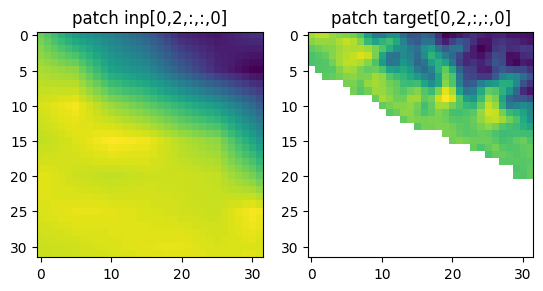

In [76]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fig, axis = plt.subplots(1, 2)
axis[ 0].imshow( tf.squeeze( inp[0,2,:,:,0]  ) )
axis[ 0].set_title("patch inp[0,2,:,:,0]")

axis[ 1].imshow( tf.squeeze( target[0,2,:,:,0]  ) )
axis[ 1].set_title("patch target[0,2,:,:,0]")
plt.show()

Corresponde expandir este método al resto de variables:
- Extracción de parches para la latitud: sampleLat()

In [77]:
def sampleLat(self):
    ll = tf.constant(self.values.latitude.values)
    vv = self.values.shape
    lat = tf.transpose(tf.broadcast_to(ll, [vv[0], vv[2], vv[1]]), perm=(0, 2, 1))
    return self.extraccion_parches(Var=lat)

Extraemos los valores asociados a la latitude de nuestro DataArray (equivalente a temp['t2m'])

In [78]:
lat_values=tf.constant(era5.values.latitude.values)
print("type: ",type(lat_values))
print("shape: ",lat_values.shape)
lat_values[:20]

type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
shape:  (401,)


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-15. , -15.1, -15.2, -15.3, -15.4, -15.5, -15.6, -15.7, -15.8,
       -15.9, -16. , -16.1, -16.2, -16.3, -16.4, -16.5, -16.6, -16.7,
       -16.8, -16.9], dtype=float32)>

Guardamos las dimensiones de nuestro DataArray en una variable:

In [79]:
dim_darray=era5.values.shape
print(dim_darray)

(40, 401, 101)


Utilizando el método ```tf.broadcast_to``` [(source)](https://www.tensorflow.org/api_docs/python/tf/broadcast_to) haremos compatibles las dimensiones de ```lat_values``` con las dimensiones de nuestro DataArray para luego transponer en el orden dado:

In [80]:
new_latitude= tf.transpose(tf.broadcast_to(lat_values, [dim_darray[0], dim_darray[2], dim_darray[1]]), perm=(0, 2, 1))
print("new latitude shape: ",new_latitude.shape)

new latitude shape:  (40, 401, 101)


Y de esta manera adaptamos nuestros valores de la latitud(que originalmente eran un tensor unidimensional de tamaño 401) a un tensor tridimensional de tamaño (40,401,101). Corresponde ahora extraer los respectivos parches.

Aplicación del método completo:

In [81]:
lat=era5.sampleLat()

100%|██████████| 38/38 [00:05<00:00,  7.07it/s]

Stack patches shape:  (1368, 3, 32, 32, 1)


- Extracción de parches para longitud: sampleLon()

In [82]:
def sampleLon(self):
    ll = tf.constant(self.values.longitude.values)
    vv = self.values.shape         
    lon = tf.broadcast_to(ll, vv)
    return self.extraccion_parches(Var=lon)

Extraemos los valores de longitud asociados a nuestro DataArray y los convertimos en un tensor de constantes: 

In [83]:
lon_values = tf.constant(era5.values.longitude.values)
print("lon values shape: ",lon_values.shape)
lon_values[:30]

lon values shape:  (101,)


<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([-75. , -74.9, -74.8, -74.7, -74.6, -74.5, -74.4, -74.3, -74.2,
       -74.1, -74. , -73.9, -73.8, -73.7, -73.6, -73.5, -73.4, -73.3,
       -73.2, -73.1, -73. , -72.9, -72.8, -72.7, -72.6, -72.5, -72.4,
       -72.3, -72.2, -72.1], dtype=float32)>

Tomamos nuevamente las dimensiones de nuestro Datarray:

In [84]:
dim_darray = era5.values.shape 
print(dim_darray)

(40, 401, 101)


Compatibilizamos las dimensiones entre el tensor con las longitudes y las dimensiones del Datarray utilizando el mismo método de antes: 

In [85]:
new_lon = tf.broadcast_to(lon_values, dim_darray)
print("shape new longitude: ",new_lon.shape)

shape new longitude:  (40, 401, 101)


Y ya estaríamos listos para extraer sus respectivos parches.

Aplicación del método completo: 

In [86]:
lon=era5.sampleLon()

100%|██████████| 38/38 [00:05<00:00,  6.95it/s]

Stack patches shape:  (1368, 3, 32, 32, 1)


- extracción de parches para la variable "Orog": sampleBand1()

In [87]:
def sampleBand1(self):
    band1 = NCFile(fName= 'dem.nc', path='')
    band1.setVar('Band1')
    band1.loadVar()
    band1.upscaleVar(self.values)
    band1.values=tf.where(tf.math.is_nan(band1.values),tf.zeros_like(band1.values),band1.values)
    stack_time=tf.repeat(band1.values, 40, axis=0)
    return band1.extraccion_parches(Var=stack_time)

Para efectos de la orografía, debemos añadirle un par de pasos extras pero nada distinto a lo que ya hemos hecho anteriormente. Lo primero es instanciar nuevamente la clase ```NCFile``` con los correspondientes inputs asociados a la ruta donde tendremos nuestros archivos con la orografía. Para nuestro caso es:

In [88]:
band1 = NCFile(fName= 'dem.nc', path='./Data/observed/2006/')

y luego repetimos los bloques (2), (3) y (4):

Importante: Antes hacíamos uso de la "Data Variable": t2m, ahora para efectos de la orografía, haremos uso de 'Band1'.

In [89]:
band1.setVar('Band1')
band1.loadVar()
band1.upscaleVar(era5.values)

<xarray.DataArray 'Band1' (time: 1, latitude: 401, longitude: 101)>
dask.array<copy, shape=(1, 401, 101), dtype=float64, chunksize=(1, 401, 101), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -15.0 -15.1 -15.2 -15.3 ... -54.8 -54.9 -55.0
  * longitude  (longitude) float32 -75.0 -74.9 -74.8 -74.7 ... -65.2 -65.1 -65.0
Dimensions without coordinates: time
Attributes:
    long_name:  GDAL Band Number 1

Un detalle importante es que nuestra orografía contiene valores Nan que ajustaremos de inmediato dentro del método ```sampleBand1()``` 

Si contamos sus valores Nan obtenemos:

In [90]:
num_nan=np.sum(tf.math.is_nan(band1.getVar()))
print(num_nan)

802


Lo último sería repetir estos valores para cada tiempo (nuestro tensor orog es de dimensiones (1,401,101)) hasta completar los 40 tiempos

In [91]:
stack_time=tf.repeat(band1.values, 40, axis=0)
print("var orog shape: ",stack_time.shape)

var orog shape:  (40, 401, 101)


Y de esta manera logramos adaptar las dimensiones de la variable orografía (```orog```) a las dimensiones del DataArray. Resta únicamente extraer los parches.

Aplicación del método completo:

In [92]:
orog=era5.sampleBand1()

100%|██████████| 38/38 [00:10<00:00,  3.57it/s]

Stack patches shape:  (1368, 3, 32, 32, 1)


Para el ajuste, reemplazaremos por ceros en las posiciones que obtenemos valores Nan:

In [93]:
band1.values=tf.where(tf.math.is_nan(band1.values),tf.zeros_like(band1.values),band1.values)
num_nan=np.sum(tf.math.is_nan(band1.values))
print(num_nan)

0


- extracción de parches para la variable time: ```sampleDayOfYear( ):```

In [94]:
def sampleDayOfYear(self):
    d = self.values.valid_time
    dd = (d-d.astype('M8[Y]')).astype(float) 
    ll = tf.constant(dd) 
    vv = self.values.shape 
    time = tf.transpose(tf.broadcast_to(ll, [vv[1], vv[2], vv[0]]), perm=(2,0,1))
    time1 = self.extraccion_parches(Var=time)
    time2 = self.extraccion_parches(Var=time, dx=4)
    return time1, time2 

Desmembremos las líneas de código que conforman esta función para entender mejor qué hace. Partimos guardando en una variable los valores de "valid_time" asociados al DataArray que hemos usado en prácticamente todas las funciones anteriores. Podemos ver que tenemos registros de tiempo cada 3 horas durante 5 días, lo que nos da un total de 40 tiempos.

In [95]:
valores_tiempo = era5.values.valid_time
valores_tiempo

<xarray.DataArray 'valid_time' (valid_time: 40)>
array(['2006-10-10T00:00:00.000000000', '2006-10-10T03:00:00.000000000',
       '2006-10-10T06:00:00.000000000', '2006-10-10T09:00:00.000000000',
       '2006-10-10T12:00:00.000000000', '2006-10-10T15:00:00.000000000',
       '2006-10-10T18:00:00.000000000', '2006-10-10T21:00:00.000000000',
       '2006-10-11T00:00:00.000000000', '2006-10-11T03:00:00.000000000',
       '2006-10-11T06:00:00.000000000', '2006-10-11T09:00:00.000000000',
       '2006-10-11T12:00:00.000000000', '2006-10-11T15:00:00.000000000',
       '2006-10-11T18:00:00.000000000', '2006-10-11T21:00:00.000000000',
       '2006-10-12T00:00:00.000000000', '2006-10-12T03:00:00.000000000',
       '2006-10-12T06:00:00.000000000', '2006-10-12T09:00:00.000000000',
       '2006-10-12T12:00:00.000000000', '2006-10-12T15:00:00.000000000',
       '2006-10-12T18:00:00.000000000', '2006-10-12T21:00:00.000000000',
       '2006-10-13T00:00:00.000000000', '2006-10-13T03:00:00.000000000',
       '2006-10-13T06:00:00.000000000', '2006-10-13T09:00:00.000000000',
       '2006-10-13T12:00:00.000000000', '2006-10-13T15:00:00.000000000',
       '2006-10-13T18:00:00.000000000', '2006-10-13T21:00:00.000000000',
       '2006-10-14T00:00:00.000000000', '2006-10-14T03:00:00.000000000',
       '2006-10-14T06:00:00.000000000', '2006-10-14T09:00:00.000000000',
       '2006-10-14T12:00:00.000000000', '2006-10-14T15:00:00.000000000',
       '2006-10-14T18:00:00.000000000', '2006-10-14T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2006-10-10 ... 2006-10-14T21:00:00
Attributes:
    long_name:  time

Lo siguiente es contar la cantidad de nanosegundos transcurridos desde el primer día del año hasta la fecha actual. Veamos un ejemplo:

In [96]:
print("Primera fecha registada: \n",valores_tiempo[0].valid_time)

Primera fecha registada: 
 <xarray.DataArray 'valid_time' ()>
array('2006-10-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    valid_time  datetime64[ns] 2006-10-10
Attributes:
    long_name:  time


In [97]:
print("Primer día del año: \n",valores_tiempo[0].astype('M8[Y]'))

Primer día del año: 
 <xarray.DataArray 'valid_time' ()>
array('2006-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    valid_time  datetime64[ns] 2006-10-10
Attributes:
    long_name:  time


Restamos ambos valores y de resultado obtendremos la cantidad de nanosegundos transcurridos:

In [98]:
diff_ns = (valores_tiempo[0]-valores_tiempo[0].astype('M8[Y]')).astype(float) 
diff_ns

<xarray.DataArray 'valid_time' ()>
array(2.43648e+16)
Coordinates:
    valid_time  datetime64[ns] 2006-10-10

Ahora extendemos esta acción para los 39 tiempos restantes y el resultado lo convertiremos en un tensor:

In [99]:
diff_tiempo = (valores_tiempo-valores_tiempo.astype('M8[Y]')).astype(float) 
diff_tiempo_tensor = tf.constant(diff_tiempo)
print("diff_tiempo_tensor shape: ",diff_tiempo_tensor.shape)
diff_tiempo_tensor[:10]

diff_tiempo_tensor shape:  (40,)


<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([2.43648e+16, 2.43756e+16, 2.43864e+16, 2.43972e+16, 2.44080e+16,
       2.44188e+16, 2.44296e+16, 2.44404e+16, 2.44512e+16, 2.44620e+16])>

Luego convalidamos las dimensiones de este tensor con las dimensiones del DataArray (lo mismo que con latitud o longitud)

In [100]:
dim_darray = era5.values.shape 
time = tf.transpose(tf.broadcast_to(diff_tiempo_tensor, [dim_darray[1], dim_darray[2], dim_darray[0]]), perm=(2,0,1))
print("time shape: ",time.shape)

time shape:  (40, 401, 101)


Finalmente queda extraer los parches a esta variable. Normalmente y para efecto de las anteriores variables, utilizábamos un stride de 32 (cada 32 elementos hacemos un corte), seguiremos en ésta linea para efectos de la variable ```time1``` pero además extraeremos parches con un stride de 4 (cada 4 elementos hacemos un corte) que guardaremos en la variable ```time2```:

In [101]:
time1 = era5.extraccion_parches(Var=time)
time2 = era5.extraccion_parches(Var=time, dx=4)
print("time1 shape: ",time1.shape)
print("time2 shape: ",time2.shape)

100%|██████████| 38/38 [00:08<00:00,  4.35it/s]


Stack patches shape:  (1368, 3, 32, 32, 1)


100%|██████████| 38/38 [10:17<00:00, 16.26s/it]

Stack patches shape:  (95000, 3, 4, 4, 1)
time1 shape:  (1368, 3, 32, 32, 1)
time2 shape:  (95000, 3, 4, 4, 1)


Ya contamos con los parches necesarios que conformarán el input completo de nuestra red:

In [102]:
print("target: ",target.shape)
print("inp: ",inp.shape)
print("lat: ",lat.shape)
print("long: ",lon.shape)
print("orog: ",orog.shape)
print("time1: ",time1.shape)
print("time2: ",time2.shape)

target:  (1368, 3, 32, 32, 1)
inp:  (1368, 3, 32, 32, 1)
lat:  (1368, 3, 32, 32, 1)
long:  (1368, 3, 32, 32, 1)
orog:  (1368, 3, 32, 32, 1)
time1:  (1368, 3, 32, 32, 1)
time2:  (95000, 3, 4, 4, 1)


#### (3) Tercera parte: Revisión de nulos, normalización y división de la data.
##### (3.1) Revisión de nulos:

In [103]:
def cantidad_nan(inputs=[]):
    '''Recorre cada variable que conforma el input de la red, y cuenta los valores nan de cada uno.
    inputs:
        inputs: [List] Lista con los inputs de la red.
    '''
    inputs_name=["target","inp","lat","lot","orog","time1","time2"]
    cantidad=[];cont=0

    for inp in inputs:
        check_nan= tf.math.is_nan(inp[:,0,:,:,0])
        cont=np.sum(check_nan)
        cantidad.append(cont)

    for nombre,num in zip(inputs_name,cantidad):
        print(f"{nombre}- num valores nan: {num}")

In [104]:
cantidad_nan(inputs=[target,inp,lat,lon,orog,time1,time2])

target- num valores nan: 452542
inp- num valores nan: 0
lat- num valores nan: 0
lot- num valores nan: 0
orog- num valores nan: 0
time1- num valores nan: 0
time2- num valores nan: 0


Intuitivamente era esperable que la cantidad de datos Nan que obtenemos en la data target debido a que ésta no registra valores numéricos para superficies que no sean terrestres:

Text(0.5, 1.0, 'target')

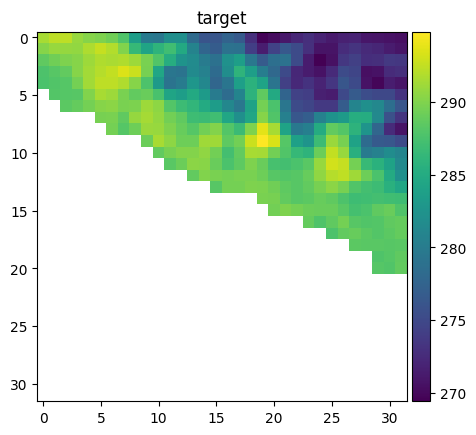

In [105]:
import matplotlib.pyplot as plt
plt.imshow( tf.squeeze( target[0,2,:,:,0]  ) )

plt.colorbar(orientation="vertical",
                 fraction=0.047,
                 pad=0.01)

plt.title('target')

Por lo mismo, también es esperable que tengamos parches que no tengan ningún dato numérico (parches que estén completamente sobre el océano):

Text(0.5, 1.0, 'target')

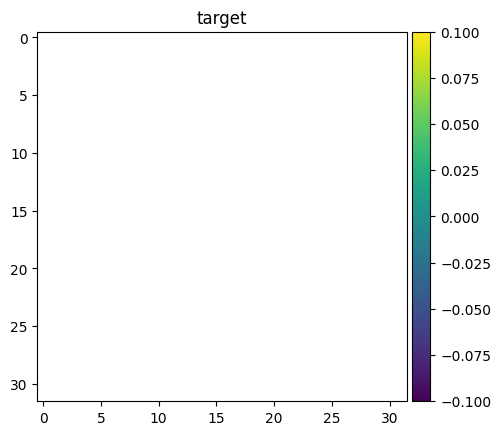

In [106]:
plt.imshow( tf.squeeze( target[3,2,:,:,0]  ) )

plt.colorbar(orientation="vertical",
                 fraction=0.047,
                 pad=0.01)

plt.title('target')

Es de vital importancia que extraigamos estos últimos parches o le causaremos problemas graves a la red. Recorreremos cada parche contando valores Nan y si esta cantidad es igual a la cantidad de elementos de dicho parche guardaremos su posición en una lista que nos permitirá filtrar estos parches en un futuro: 

In [107]:
def parches_nan_target(patch_target):
    ''' Recorremos cada parche dentro de target y contamos sus valores Nan, si estos resultan igual a la cantidad de elementos de dicho parche
        (32*32=1024) guardamos su índice en una lista.
    inp:
        patch_target: [tensor] tensor que contiene los parches extraídos de target

    return:
        idx: [list] posición de los parches que no están completamente compuestos con Nan's
    '''
    idx_nulos=[]

    for i in range(patch_target.shape[0]):
        check_nan= tf.math.is_nan(patch_target[i,0,:,:,0])
        if np.sum(check_nan) == patch_target.shape[2]* patch_target.shape[3]: #32*32
            idx_nulos.append(i)
    print("Cantidad de parches nulos: ",len(idx_nulos))

    #filtramos las posiciones de los parches completos de Nan's
    idx= [x for x in range(0,patch_target.shape[0]) if x not in idx_nulos]
    print("Cantidad de parches no nulos: ",len(idx))
    return idx

In [108]:
idx=parches_nan_target(target)

Cantidad de parches nulos:  152
Cantidad de parches no nulos:  1216


In [109]:
def filtracion_nan(target,inp,lat,lon,orog,time1,idx):
    ''' A través del método tf.gather(), descarta los parches completos de Nan y retorna los nuevos parches que conformarán el input de la red.
    input:
        -target,inp,lat,lon,orog,time1: [tensor] tensor que contiene los parches de cada variable que conforma al input
        idx: [list] Poisición de los parches que no están completados únicamente con Nan
    return:
        Retorna los nuevos parches limpios para cada variable.
    '''
    
    target_clean=tf.gather( target, idx, axis=0)
    inp_clean=tf.gather( inp, idx, axis=0)
    lat_clean=tf.gather( lat, idx, axis=0)
    lon_clean= tf.gather( lon, idx, axis=0)
    orog_clean = tf.gather( orog, idx, axis=0)
    time1_clean = tf.gather( time1, idx, axis=0)

    return target_clean, inp_clean, lat_clean, lon_clean, orog_clean, time1_clean

In [110]:
target,inp,lat,long,orog,time1=filtracion_nan(target,inp,lat,lon,orog,time1,idx)

In [111]:
print("target: ",target.shape)
print("inp: ",inp.shape)
print("lat: ",lat.shape)
print("long: ",long.shape)
print("orog: ",orog.shape)
print("time1: ",time1.shape)
print("time2: ",time2.shape)

target:  (1216, 3, 32, 32, 1)
inp:  (1216, 3, 32, 32, 1)
lat:  (1216, 3, 32, 32, 1)
long:  (1216, 3, 32, 32, 1)
orog:  (1216, 3, 32, 32, 1)
time1:  (1216, 3, 32, 32, 1)
time2:  (95000, 3, 4, 4, 1)


Chequeamos nuevamente la existencia de parches nulos: 

In [112]:
idx_check=parches_nan_target(target)

Cantidad de parches nulos:  0
Cantidad de parches no nulos:  1216


Ya hemos limpiado nuestro target y comprobado que el resto de variables no contenga parches Nan's. 
- (3.2) Normalización:

In [113]:
def normalization( data_in=input,inverse=False, scale_factor=[1,1]):
    '''
        :param data_in: variable a normalizar
        :param inverse: True en caso de devolver la transformación
        :return: variable normalizada
    '''
    if not inverse:
        scale_factor_ = np.max(np.abs(data_in))
        scale_factor_2 = np.min(np.abs(data_in))
        data_out = (data_in-scale_factor_2)/(scale_factor_ - scale_factor_2)
        scale_factor_ = [scale_factor_,scale_factor_2]
    else:
        data_out=(data_in * (scale_factor[0]-scale_factor[1]))+scale_factor[1]
        scale_factor_ = scale_factor
    return data_out, scale_factor_

Para efectos de la normalización, utilizaremos la siguiente fórmula para cada una de las variables que conforman el input:
$$ \text{normalization(data)} := \dfrac{data - \min(data)}{\max(data) - \min(data)}= \text{nueva data}$$
donde min(data) y max(data) corresponderán al mínimo y máximo valor de nuestra variable a normalizar respectivamente. Además, esta función nos ofrece el "poder devolvernos" pensando una vez tengamos la salida de nuestra red. Para ello, la función a través de su parámetro ```inverse=True``` aplica la siguiente fórmula:

$$ \text{normalization inverse (nueva data)} := \text{nueva data} \cdot (\max(data) - \min(data)) + (\min(data))= data $$

In [114]:
target_norm, scale_factor_target = era5.normalization(target)
inp_norm, scale_factor_inp = era5.normalization(inp)
lat_norm, scale_factor_lat = era5.normalization(lat)
lon_norm, scale_factor_lon = era5.normalization(long)
orog_norm, scale_factor_orog = era5.normalization(orog)
time_norm, scale_factor_time = era5.normalization(time1)

- (3.3) División de la data: 

In [115]:
def mysplit(inp, time, orog, lat, lon, target):
        data = tf.concat([tf.cast(inp, dtype=tf.float32),
                      tf.cast(time, dtype=tf.float32),
                      tf.cast(orog, dtype=tf.float32),
                      tf.cast(lat, dtype=tf.float32),
                      tf.cast(lon, dtype=tf.float32),
                      tf.cast(target, dtype=tf.float32)], axis=4)
        data = tf.random.shuffle(data, seed=10)
        n = data.shape[0]
        n_train = int(n * .6)
        n_valid = int(n * .2)
        n_test = n - n_train - n_valid
        data = tf.split(data, [n_train, n_valid, n_test])
        return (tf.expand_dims(data[0][:, :, :, :, 0],4),
            tf.expand_dims(data[0][:, :, :, :, 1],4),
            tf.expand_dims(data[0][:, :, :, :, 2],4),
            tf.expand_dims(data[0][:, :, :, :, 3],4),
            tf.expand_dims(data[0][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[0][:,1,:,:,5],1),4),
            tf.expand_dims(data[1][:, :, :, :, 0],4),
            tf.expand_dims(data[1][:, :, :, :, 1],4),
            tf.expand_dims(data[1][:, :, :, :, 2],4),
            tf.expand_dims(data[1][:, :, :, :, 3],4),
            tf.expand_dims(data[1][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[1][:,1,:,:,5],1),4),
            tf.expand_dims(data[2][:, :, :, :, 0],4),
            tf.expand_dims(data[2][:, :, :, :, 1],4),
            tf.expand_dims(data[2][:, :, :, :, 2],4),
            tf.expand_dims(data[2][:, :, :, :, 3],4),
            tf.expand_dims(data[2][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[2][:,1,:,:,5],1),4))

In [116]:
(inp_tr,time_tr,orog_tr,lat_tr,lon_tr,target_tr,
 inp_va,time_va,orog_va,lat_va,lon_va,target_va,
 inp_te,time_te, orog_te,lat_te,lon_te, target_te) = era5.mysplit(inp_norm,time_norm,orog_norm,lat_norm,lon_norm,target_norm)

Resumen división de la data:

In [117]:
print("#"*10+" "+"Entrenamiento"+" "+"#"*10)
print("target: ",target_tr.shape)
print("inp: ",inp_tr.shape)
print("lat: ",lat_tr.shape)
print("long: ",lon_tr.shape)
print("orog: ",orog_tr.shape)
print("time1: ",time_tr.shape)

########## Entrenamiento ##########
target:  (729, 1, 32, 32, 1)
inp:  (729, 3, 32, 32, 1)
lat:  (729, 3, 32, 32, 1)
long:  (729, 3, 32, 32, 1)
orog:  (729, 3, 32, 32, 1)
time1:  (729, 3, 32, 32, 1)


In [118]:
print("#"*10+" "+"Validación"+" "+"#"*10)
print("target: ",target_va.shape)
print("inp: ",inp_va.shape)
print("lat: ",lat_va.shape)
print("long: ",lon_va.shape)
print("orog: ",orog_va.shape)
print("time1: ",time_va.shape)

########## Validación ##########
target:  (243, 1, 32, 32, 1)
inp:  (243, 3, 32, 32, 1)
lat:  (243, 3, 32, 32, 1)
long:  (243, 3, 32, 32, 1)
orog:  (243, 3, 32, 32, 1)
time1:  (243, 3, 32, 32, 1)


In [119]:
print("#"*10+" "+"Testeo"+" "+"#"*10)
print("target: ",target_te.shape)
print("inp: ",inp_te.shape)
print("lat: ",lat_te.shape)
print("long: ",lon_te.shape)
print("orog: ",orog_te.shape)
print("time1: ",time_te.shape)

########## Testeo ##########
target:  (244, 1, 32, 32, 1)
inp:  (244, 3, 32, 32, 1)
lat:  (244, 3, 32, 32, 1)
long:  (244, 3, 32, 32, 1)
orog:  (244, 3, 32, 32, 1)
time1:  (244, 3, 32, 32, 1)


- (3.4) Ajustes de las dimensiones para time1: 

Aclaración importante. Desconozco (de momento) el argumento de por qué se hace este reajuste, pero como nos interesa copiar la metodología empleada en el archivo del cual nos estamos basando, implementaremos esta modificación.

La variable relacionada al tiempo que finalmente será parte del input general para nuestra red será la variable ```time2``` (en la cual empleábamos un stride de 4). Su reajuste se basa en 3 sencillos pasos: 
- - (3.4.1) Truncamiento: Nos interesan los primeros 1216 valores de esta variable (recordar que 1216 representa la cantidad de parches por variable post limpieza de parches Nan)

In [120]:
time2_cut=time2[:inp_norm.shape[0]]
print("shape time 2 antes del corte: ", time2.shape)
print("shape  time 2 después del corte:  ",time2_cut.shape)

shape time 2 antes del corte:  (95000, 3, 4, 4, 1)
shape  time 2 después del corte:   (1216, 3, 4, 4, 1)


- - (3.4.2) Normalización: Aplicamos el mismo método empleado para normalizar las variables anteriores:

In [121]:
time_norm, scale_factor_time=era5.normalization(time2_cut)

- - (3.4.3) Segmentación de la variable: 

In [122]:
#para el entreno:
time2_tr =time_norm[:inp_tr.shape[0]]
print("inp_tr.shape[0]: ", inp_tr.shape[0])
print("time2_tr shape: ", time2_tr.shape)

inp_tr.shape[0]:  729
time2_tr shape:  (729, 3, 4, 4, 1)


In [123]:
#para la validación:
time2_va = time_norm[inp_tr.shape[0]:inp_tr.shape[0]+inp_va.shape[0]]
print(f"(inp_tr.shape[0]) {inp_tr.shape[0]} + (inp_va.shape[0]) {inp_va.shape[0]} = {inp_tr.shape[0]+inp_va.shape[0]}")
print("time2_va shape: ", time2_va.shape)

(inp_tr.shape[0]) 729 + (inp_va.shape[0]) 243 = 972
time2_va shape:  (243, 3, 4, 4, 1)


In [124]:
#para testeo:
time2_te = time_norm[inp_tr.shape[0]+inp_va.shape[0]:inp_norm.shape[0]]
print("inp_norm.shape[0]: ", inp_norm.shape[0])
print("time2_te shape: ", time2_te.shape)

inp_norm.shape[0]:  1216
time2_te shape:  (244, 3, 4, 4, 1)


Con esto concluímos todo el preprocesamiento necesario para los inputs de nuestra red.  